**NOTE!** The code uses processed data from the LHCb experiment. Collaboration members please write nikita.kazeev@cern.ch for access.

In [1]:
from deep_ensembles import nets, data
from deep_ensembles.params import *
from deep_ensembles.train import train, repeater, ParticleSet
from deep_ensembles.eval import count_model_accuracy, count_uncertainty, eval_model_by_classifier, eval_model_by_ks

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/lhcb'
import os
import numpy as np

def get_particle_dset(particle):
    return [os.path.join(data_dir, name) for name in os.listdir(data_dir) if particle in name]

datasets = {particle: get_particle_dset(particle) for particle in PARTICLES} 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
_, _, _, data_train_s, data_val_s, data_test_s, scaler = data.get_val_dataset(datasets, PARTICLE_TYPE, dtype=np.float32, log=True)

In [4]:
import torch
N_VAL = int(3e5)
val_loader = repeater(torch.utils.data.DataLoader(ParticleSet(data_val_s),
                                                  batch_size=N_VAL,
                                                  shuffle=False,
                                                  pin_memory=True))

In [5]:
from tqdm import tqdm
def chunk_indices(freq, chunk_size=150000):
    freq_ravel = freq.ravel()

    freq_indices_sorted = np.argsort(-freq_ravel)

    total = 0
    chunks = []
    batch_chunk_indices = []
    for freq_id in freq_indices_sorted:
        freq = freq_ravel[freq_id]

        total += freq
        batch_chunk_indices.append(freq_id)

        if total > chunk_size:
            chunks.append(batch_chunk_indices)

            total = 0
            batch_chunk_indices = []

    if len(batch_chunk_indices) > 0:
        chunks.append(batch_chunk_indices)

    return chunks


def get_grid_intervals(x, y):
    def make_intervals(array):
        left = array[:-1]
        right = array[1:]

        return list(zip(left, right))

    x_ints, y_ints = make_intervals(x), make_intervals(y)

    all_intvals = []

    for r in tqdm(x_ints):
        for c in y_ints:
            all_intvals.append((r, c))

    all_intvals = np.array(all_intvals)
    
    return all_intvals


def select_chunk_indices(x, y, chunk_intervals):
    indices = []

    for chunk_intval in chunk_intervals:
        x_l, x_r = chunk_intval[0]
        y_l, y_r = chunk_intval[1]

        mask = (x >= x_l) & (x < x_r) & (y >= y_l) & (y < y_r)
        ids = np.argwhere(mask == 1)
        indices.extend(ids)

    indices = np.array(indices)

    return indices.squeeze()


def _split_by_density_rings(x, y, bins=200):
    freq, x_range, y_range = np.histogram2d(x, y, bins=bins)
    chunks = chunk_indices(freq)

    print("Computing intvals")
    intvals = get_grid_intervals(x_range, y_range)
    print("Intvals computed")

    rings_indices = []
    for chunk in tqdm(chunks):
        intval = intvals[chunk]
        ids = select_chunk_indices(x, y, intval)
        rings_indices.append(ids)

    return rings_indices


def split_by_density_rings(data):
    x = data['Brunel_P'].to_numpy()
    y = data['Brunel_ETA'].to_numpy()

    rings_indices = _split_by_density_rings(x, y)

    data_rings = []
    for ring_ids in rings_indices:
        data_rings.append(data.iloc[ring_ids])

    return data_rings, rings_indices


rings = split_by_density_rings(data_val_s)
data_rings, rings_indices = rings

  0%|          | 0/7 [00:00<?, ?it/s]

Computing intvals
Intvals computed


100%|██████████| 7/7 [01:41<00:00, 14.56s/it]


In [6]:
import pandas as pd 
import torch 

rings_loaders = []
samples_num = np.inf
for ring in list(data_rings):
    data = pd.DataFrame(data=ring, columns=['RichDLLe', 'RichDLLk', 'RichDLLmu', 'RichDLLp', 'RichDLLbt', 'Brunel_P', 'Brunel_ETA', 'nTracks_Brunel', 'probe_sWeight'])
    data_loader = repeater(torch.utils.data.DataLoader(ParticleSet(data),
                                                      batch_size=data.shape[0],
                                                      shuffle=False,
                                                      pin_memory=True))
    rings_loaders.append(data_loader)
    print(ring.shape)
    samples_num = min(samples_num, ring.shape[0])
print('min shape:', samples_num)

(150205, 9)
(150202, 9)
(150034, 9)
(150004, 9)
(150030, 9)
(150018, 9)
(99505, 9)
min shape: 99505


In [7]:
import torch
torch.cuda.is_available()
num_models = 10

In [40]:
num_models = 10
device = 'cuda'
NUM_LAYERS = 5
models_path = 'generators_without_weights(5).pt'
models_path = '/content/drive/MyDrive/agatha_data/rich_more_var_ad/generators_without_weights.pt'

netGs = nets.GeneratorEnsemble(num_models=num_models, depth=NUM_LAYERS).to(device)
netGs.load_state_dict(torch.load(models_path, map_location=torch.device(device))['model_state_dict'])
netGs.eval()

GeneratorEnsemble(
  (Gmodel_0): Generator(
    (layers): Sequential(
      (0): Linear(in_features=67, out_features=128, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (3): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (4): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (5): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (6): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): ReLU()
      )
      (7): Linear(in_features=128, out_features=5, bias=True)
    )
  )
  (Gmodel_1): Generator(
    (layers): Sequential(
      (0): Linear(in_features=67, out_features=128, bias=True)
      (1): ReLU()
      (2): Sequential(
        (0): Linear(in_features=128, 

In [17]:
device = 'cuda'
for ring in rings_loaders:
    x, _, dlls = [i.to(device) for i in next(ring)]
    samples_num = x.shape[0] // num_models * num_models
    print(samples_num, x.shape[0])
    acc = count_model_accuracy(x, scaler, dlls, netGs, eval_model_by_classifier, samples_num) 
    unc = count_uncertainty(x[:samples_num], scaler, netGs, eval_model_by_classifier, samples_num // num_models, num_models) 
    accs.append(acc)
    uncs.append(unc)
    

150200 150202


/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.94s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.03s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.24s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:37<00:00, 12.40s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.95s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.89s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.07s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.73s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.92s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.12s/it]


150030 150034


/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.73s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.97s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.15s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.19s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.63s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.98s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.79s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.78s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.58s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:38<00:00, 12.69s/it]


150000 150004


/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.51s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.42s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.43s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.68s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.53s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.93s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.50s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.52s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.48s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:35<00:00, 11.91s/it]


150030 150030


/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.28s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.30s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.27s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:34<00:00, 11.34s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.08s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.25s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.12s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.25s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.33s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:36<00:00, 12.25s/it]


150010 150018


/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:31<00:00, 10.65s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.88s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.94s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.91s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.99s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.91s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.90s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:33<00:00, 11.03s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:32<00:00, 10.94s/it]
/content/deep_ensembles/eval.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  model_preds = torch.tensor(preds[i][:samples_num]).cpu()
/content/deep_ensembles/eval.py:138: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dll = torch.tensor(dll[:samples_num]).cpu()
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
  0%|          | 0/3 [00:00<?, ?it/s]

start eval


/usr/local/lib/python3.7/dist-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +
100%|██████████| 3/3 [00:37<00:00, 12.36s/it]


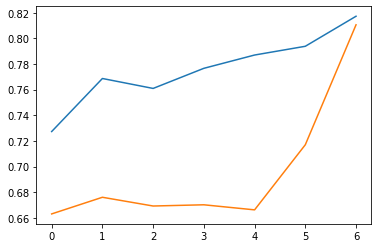

In [28]:
import matplotlib.pyplot as plt

plt.plot([np.array(u).mean() for u in uncs])
plt.plot([np.array(u).mean() for u in accs])
plt.show()